In [1]:
%load_ext autoreload
%autoreload 2

from Shared.shared import *
from Shared.specific_CNB_sim import *

sim_name = f"Dopri5_1k"
sim_folder = f"sim_output/{sim_name}"
fig_folder = f"figures_local/{sim_name}"
Cl_folder = f"Shared/Cls"
nu_m_range = jnp.load(f"{sim_folder}/neutrino_massrange_eV.npy")
nu_m_picks = jnp.array([0.01, 0.05, 0.1, 0.2, 0.3])*Params.eV
simdata = SimData(sim_folder)

exclude_nums = [
    20,  # broken halo
    25,  #? halo with only underdensities? look at skymap for this one...
]

## Overdensity band

In [ ]:
tot_dens_halos = jnp.load(f"{sim_folder}/total_densities.npy")
ic(tot_dens_halos.shape)

tot_dens_halos_PFs = jnp.load(f"{sim_folder}/total_densities_incl_PFs.npy")
ic(tot_dens_halos_PFs.shape)

SimPlot.overdensity_band(
    dens_FD=tot_dens_halos,
    dens_PF=tot_dens_halos_PFs,
    m_arr_FD=nu_m_range,
    m_arr_PF=nu_m_picks,
    plot_ylims=(1e-4,1e1),
    plot_log=True,
    fig_path=f"{fig_folder}/overdensity_band_{sim_name}.pdf",
    args=Params())

## Anisotropy Skymaps and Power Spectra

In [ ]:
nu_vectors = jnp.load(f"{sim_folder}/vectors_halo1.npy")
ic(nu_vectors.shape)

nu_dens = Physics.number_densities_all_sky(
    v_arr=nu_vectors[..., 3:],
    m_arr=nu_m_range,
    pix_sr=simdata.pix_sr,
    args=Params())
ic(nu_dens.shape)

In [ ]:
# Choose which halo to plot
halo_i = 1

# Load associated origID of chosen halo
halo_indices = jnp.load(
    f"{sim_folder}/halo_batch_0.6-2.0x1e+12.0_Msun_indices.npy")
haloID = halo_indices[halo_i-1]

# Choose which neutrino mass to plot
m_val = 0.01
m_idx = jnp.abs(nu_m_range - m_val).argmin()

# Load corresponding number densities
CNB_dens_1mass = nu_dens[m_idx]
ic(CNB_dens_1mass.shape)
ic(CNB_dens_1mass.min(), CNB_dens_1mass.max())

CNB_skymap, DM_halo_skymap = SimPlot.skymaps_CNBxDM(
    nu_mass=m_val, 
    CNB_dens=CNB_dens_1mass, 
    DM_halo_pos=jnp.load(f"Data/halo_grids/DM_pos_origID{haloID}_snap_0036.npy"), 
    init_xyz=jnp.load(f"{sim_folder}/init_xyz_halo{halo_i}.npy"), 
    fig_path=f"{fig_folder}/skymaps_CNBxDM_{sim_name}.pdf",
    args=Params())

## Phase-space distributions today

ic| Deltas_sort.shape: (10, 5, 768, 1000)
ic| p_z4_sort.shape: (10, 5, 768, 1000)


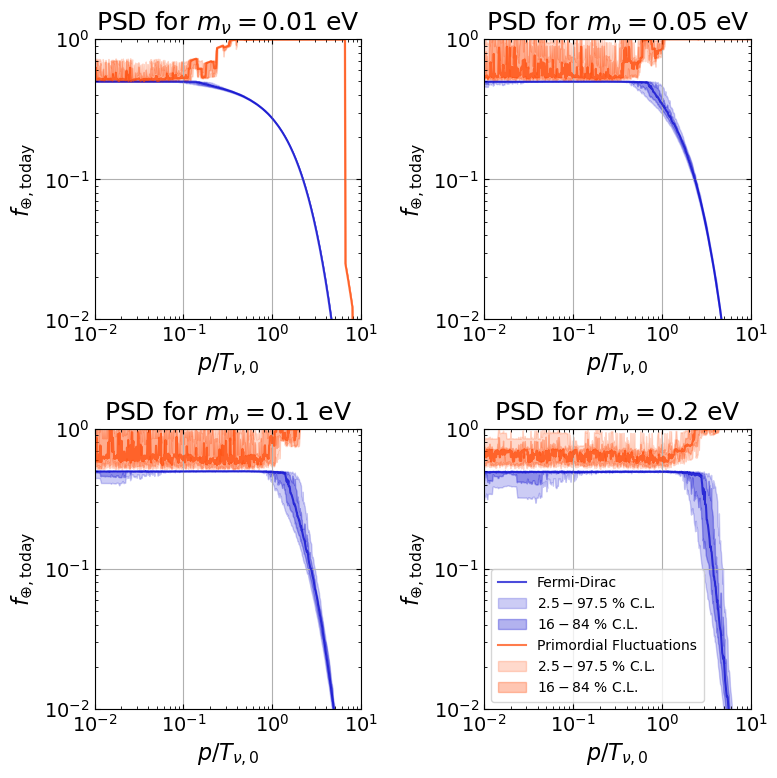

In [3]:
SimPlot.phase_space_2x2_FD_vs_PF(
    sim_dir=sim_folder, 
    m_picks=nu_m_picks, 
    halo_num=10, 
    fig_dir=fig_folder)

#note TODO: 
# - add original Fermi-Dirac in amgenta dotted
# - add escape momentum vertical band
# - fix primordial fluctuations PSD

# Using Primordial Fluctuations (PF) PSD

## Temperature fluctuation skymaps from Cl

In [ ]:
SimPlot.temp_deltas_skymaps(
    m_Cl=0.01, 
    q_select=Primordial.q_select, 
    Cl_qi=Primordial.Cl_qi, 
    seed=5, 
    Nside=simdata.Nside,
    z4_val=simdata.z4_sim_val,
    Cl_dir=Cl_folder, 
    fig_dir=fig_folder,
    args=Params)

SimPlot.temp_deltas_skymaps(
    m_Cl=0.05, 
    q_select=Primordial.q_select, 
    Cl_qi=Primordial.Cl_qi, 
    seed=5, 
    Nside=simdata.Nside,
    z4_val=simdata.z4_sim_val,
    Cl_dir=Cl_folder, 
    fig_dir=fig_folder,
    args=Params)

In [ ]:
print(f"Values from Tully & Zhang (2021) Fig. 5 left for 0.05 eV and q-averaged:")
conv_unit = Primordial.uK/Params.T_CNB*100
TZ_val_left = -176166*conv_unit
TZ_val_right = 157773*conv_unit
print(f"{TZ_val_left:.4f} to {TZ_val_right:.4f} % of T_CNB")

## Inspect number density files

In [5]:
# Fermi-Dirac distribution assumption
# note: total densities are computed for length 50 mass range
pix_dens_FD = jnp.load(f"{sim_folder}/pixel_densities.npy")
tot_dens_FD = jnp.load(f"{sim_folder}/total_densities.npy")
print(pix_dens_FD.shape)
print(tot_dens_FD.shape)

# Incl. primordial fluctuations
# note: all sky densities are computed for 5 specific masses
pix_dens_PF = jnp.load(f"{sim_folder}/pixel_densities_incl_PFs.npy")
tot_dens_PF = jnp.load(f"{sim_folder}/total_densities_incl_PFs.npy")
print(pix_dens_PF.shape)
print(tot_dens_PF.shape)

# Deltas = jnp.load(f"{sim_folder}/Deltas_halos.npy")
# ic(Deltas.shape)

(10, 50, 768)
(10, 50)
(10, 5, 768)
(10, 5)


## Comparison of FD & PF skymaps

ic| FD_skymap.sum()*N0_pix/(Params.cm**-3): Array(58.34244046, dtype=float64)
ic| PF_skymap.sum()*N0_pix/(Params.cm**-3): Array(265729.82145049, dtype=float64)


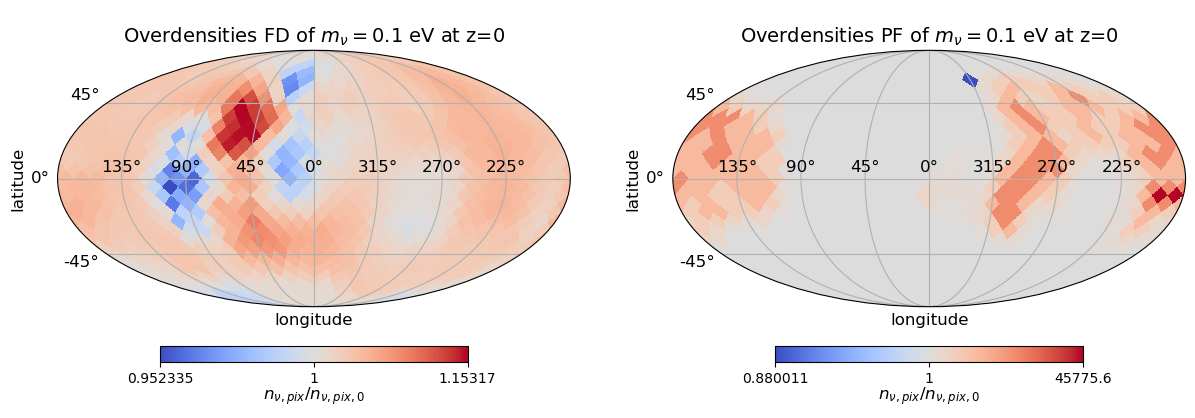

In [6]:
# Choose a halo and mass to display
halo_i = 1
m_pick = 0.1
mPF_i = jnp.abs(nu_m_picks - m_pick).argmin()
mFD_i = jnp.abs(nu_m_range - m_pick).argmin()

N0_pix = Params.N0 / simdata.Npix
skymap_norm = N0_pix / (Params.cm**-3)

### ------------------------------------------- ###
### Plot parameters for Fermi-Dirac (FD) skymap ###
### ------------------------------------------- ###

FD_skymap = pix_dens_FD[halo_i, mFD_i, :] / skymap_norm
ic(FD_skymap.sum()*N0_pix/(Params.cm**-3))

# Make center value to be 1 (no overdensity).
mid_FD = 1.
divnorm_FD = mcolors.TwoSlopeNorm(vcenter=mid_FD)

# Plot style healpy dictionary for left skymap
dict_FD = dict(
    title=fr"Overdensities FD of $m_\nu={m_pick}$ eV at z=0", 
    unit=r"$n_{\nu, pix} / n_{\nu, pix, 0}$",
    cmap="coolwarm",
    override_plot_properties={"cbar_pad": 0.1},
    cbar_ticks=[np.min(FD_skymap), mid_FD, np.max(FD_skymap)],
    norm=divnorm_FD,
    sub=121)


### ------------------------------------------------------- ###
### Plot parameters for Primordial Fluctuations (FD) skymap ###
### ------------------------------------------------------- ###

PF_skymap = pix_dens_PF[halo_i, mPF_i, :] / skymap_norm
ic(PF_skymap.sum()*N0_pix/(Params.cm**-3))

# Make center value to be 1 (no overdensity).
mid_PF = 1.
divnorm_PF = mcolors.TwoSlopeNorm(vcenter=mid_PF)

# Plot style healpy dictionary for right skymap
dict_PF = dict(
    title=fr"Overdensities PF of $m_\nu={m_pick}$ eV at z=0", 
    unit=r"$n_{\nu, pix} / n_{\nu, pix, 0}$",
    cmap="coolwarm",
    override_plot_properties={"cbar_pad": 0.1},
    cbar_ticks=[np.min(PF_skymap), mid_PF, np.max(PF_skymap)],
    norm=divnorm_PF,
    sub=122)


### ------------ ###
### Plot skymaps ###
### ------------ ###

SimPlot.healpix_side_by_side(
    map_left=FD_skymap,
    map_right=PF_skymap,
    dict_left=dict_FD,
    dict_right=dict_PF,
    fig_path=fig_folder,
    args=Params)  

## Comparison of FD & PF power spectra

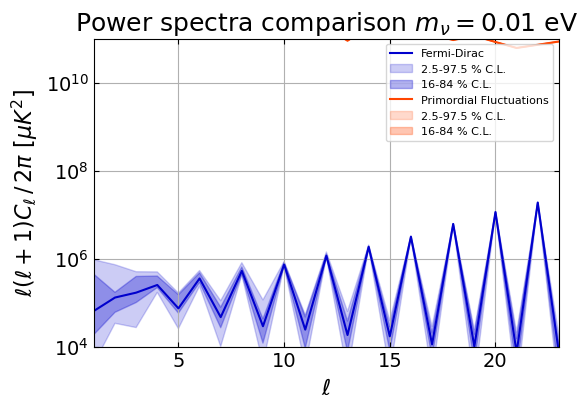

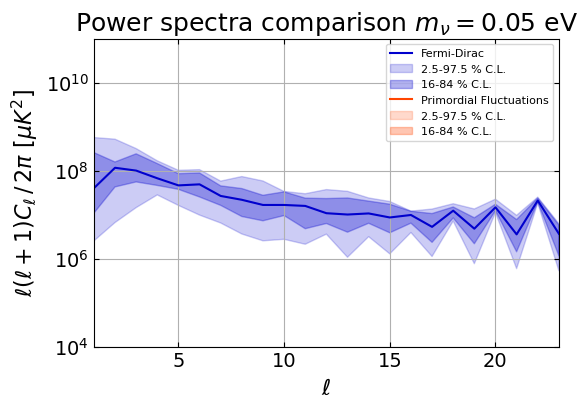

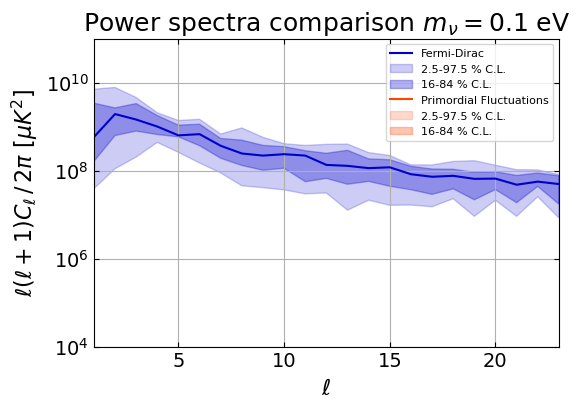

In [7]:
skymap_norm = N0_pix / (Params.cm**-3)
for m_pick in (0.01, 0.05, 0.1):
    SimPlot.power_spectra_FDxPF(
        m_pick=m_pick, 
        pix_dens_FD=pix_dens_FD / skymap_norm, 
        pix_dens_PF=pix_dens_PF / skymap_norm, 
        sim_dir=sim_folder, 
        fig_dir=fig_folder,
        args=Params)

# Other code

In [ ]:
def momentum_distribution(y_arr, nbins, args):
    """
    Plot a momentum histogram with logarithmically spaced bins.
    """

    # Generating logarithmically spaced bins
    log_bins = np.logspace(
            np.log10(np.min(y_arr)), np.log10(np.max(y_arr)), nbins)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    # Plot simulation distances
    ax.hist(
        y_arr, bins=log_bins, 
        color="blue", label="CNB simulation", alpha=0.8)
    
    ax.set_xscale("log")
    ax.set_title("Momentum distribution at z=4 (Log Bins)")
    ax.set_xlabel(r"$p_\mathrm{back}/T_\mathrm{CNB,0}$")
    ax.set_ylabel("Nr. of neutrinos")
    ax.legend(loc="upper left")

    plt.show(); plt.close()


def cartesian_to_healpix(Nside_map, xyz_pos_in, obs_pos_in):

    # Center on observer position.
    xyz_pos = xyz_pos_in - obs_pos_in
    x, y, z = xyz_pos[:,0], xyz_pos[:,1], xyz_pos[:,2]

    # Convert x,y,z to angles.
    proj_xy_plane_dis = np.sqrt(x**2 + y**2)

    thetas = np.arctan2(z, proj_xy_plane_dis)
    phis = np.arctan2(y, x)

    # To galactic latitude and longitude (in degrees) for healpy.
    hp_glon, hp_glat = np.rad2deg(phis), np.rad2deg(thetas)

    # Convert angles to pixel indices using ang2pix.
    pixel_indices = hp.ang2pix(
            Nside_map, hp_glon, hp_glat, lonlat=True)

    # Create a Healpix map and increment the corresponding pixels
    healpix_map = np.zeros(hp.nside2npix(Nside_map))
    np.add.at(healpix_map, pixel_indices, 1)

    return pixel_indices, healpix_map